In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Concatenate,UpSampling2D,SpatialDropout2D,Input,AveragePooling2D

from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt


Unet like architecture proposed

In [10]:
def Unet(input_size):
    """encoder"""
    #block 1 
    input_scan = Input(input_size)
    conv1 = Conv2D(32,(3,3),padding="same",activation= 'relu')(input_scan)
    conv1 = Conv2D(32,(3,3),padding="same",activation= 'relu')(conv1)
  
    pool1 = MaxPooling2D((2,2),strides=2)(conv1)
    #block 2
    conv2 = Conv2D(64,(3,3),padding="same",activation= 'relu')(pool1)
    conv2 = Conv2D(64,(3,3),padding="same",activation= 'relu')(conv2)
    pool2 = MaxPooling2D((2,2),strides=2)(conv2)
    #block 3
    conv3  = Conv2D(128,(3,3),padding="same",activation= 'relu')(pool2)
    conv3 = Conv2D(128,(3,3),padding="same",activation= 'relu')(conv3)
    pool3 = MaxPooling2D((2,2),strides=2)(conv3)
    #block 4
    conv4  = Conv2D(256,(3,3),padding="same",activation= 'relu')(pool3)
    conv4 = Conv2D(256,(3,3),padding="same",activation= 'relu')(conv4)
    pool4 = MaxPooling2D((2,2),strides=2)(conv4)
    #block 5
    conv5  = Conv2D(512,(3,3),padding="same",activation= 'relu')(pool4)
    conv5  = Conv2D(512,(3,3),padding="same",activation= 'relu')(conv5)
   
    """decoder"""
    #block 1
    up1 =UpSampling2D((2,2))(conv5)
    merg1 =  Concatenate()([up1,conv4])
    dconv1  = Conv2D(256,(3,3),padding="same",activation= 'relu')(merg1)
    dconv1  = Conv2D(256,(3,3),padding="same",activation= 'relu')(dconv1)
    #block 2
    up2 =UpSampling2D((2,2))(dconv1)
    merg2 =  Concatenate()([up2,conv3])
    dconv2  = Conv2D(128,(3,3),padding="same",activation= 'relu')(merg2)
    dconv2  = Conv2D(128,(3,3),padding="same",activation= 'relu')(dconv2)
    
    #block 3
    up3 =UpSampling2D((2,2))(dconv2)
    merg3 =  Concatenate()([up3,conv2])
    dconv3  = Conv2D(64,(3,3),padding="same",activation= 'relu')(merg3)
    dconv3  = Conv2D(64,(3,3),padding="same",activation= 'relu')(dconv3)
    #block 4
    up4 =UpSampling2D((2,2))(dconv3)
    merg4 =  Concatenate()([up4,conv1])
    dconv4  = Conv2D(32,(3,3),padding="same",activation= 'relu')(merg4)
    dconv4  = Conv2D(32,(3,3),padding="same",activation= 'relu')(dconv4)

    out_put = Conv2D(1,1,padding ='same',activation= 'sigmoid')(dconv4)
    model = tf.keras.Model(input_scan,out_put,name='U_net')
    return model

In [11]:
model = Unet((512,512,1))

In [12]:
model.summary()

Model: "U_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_19[0][0]']              
                                )                                                             

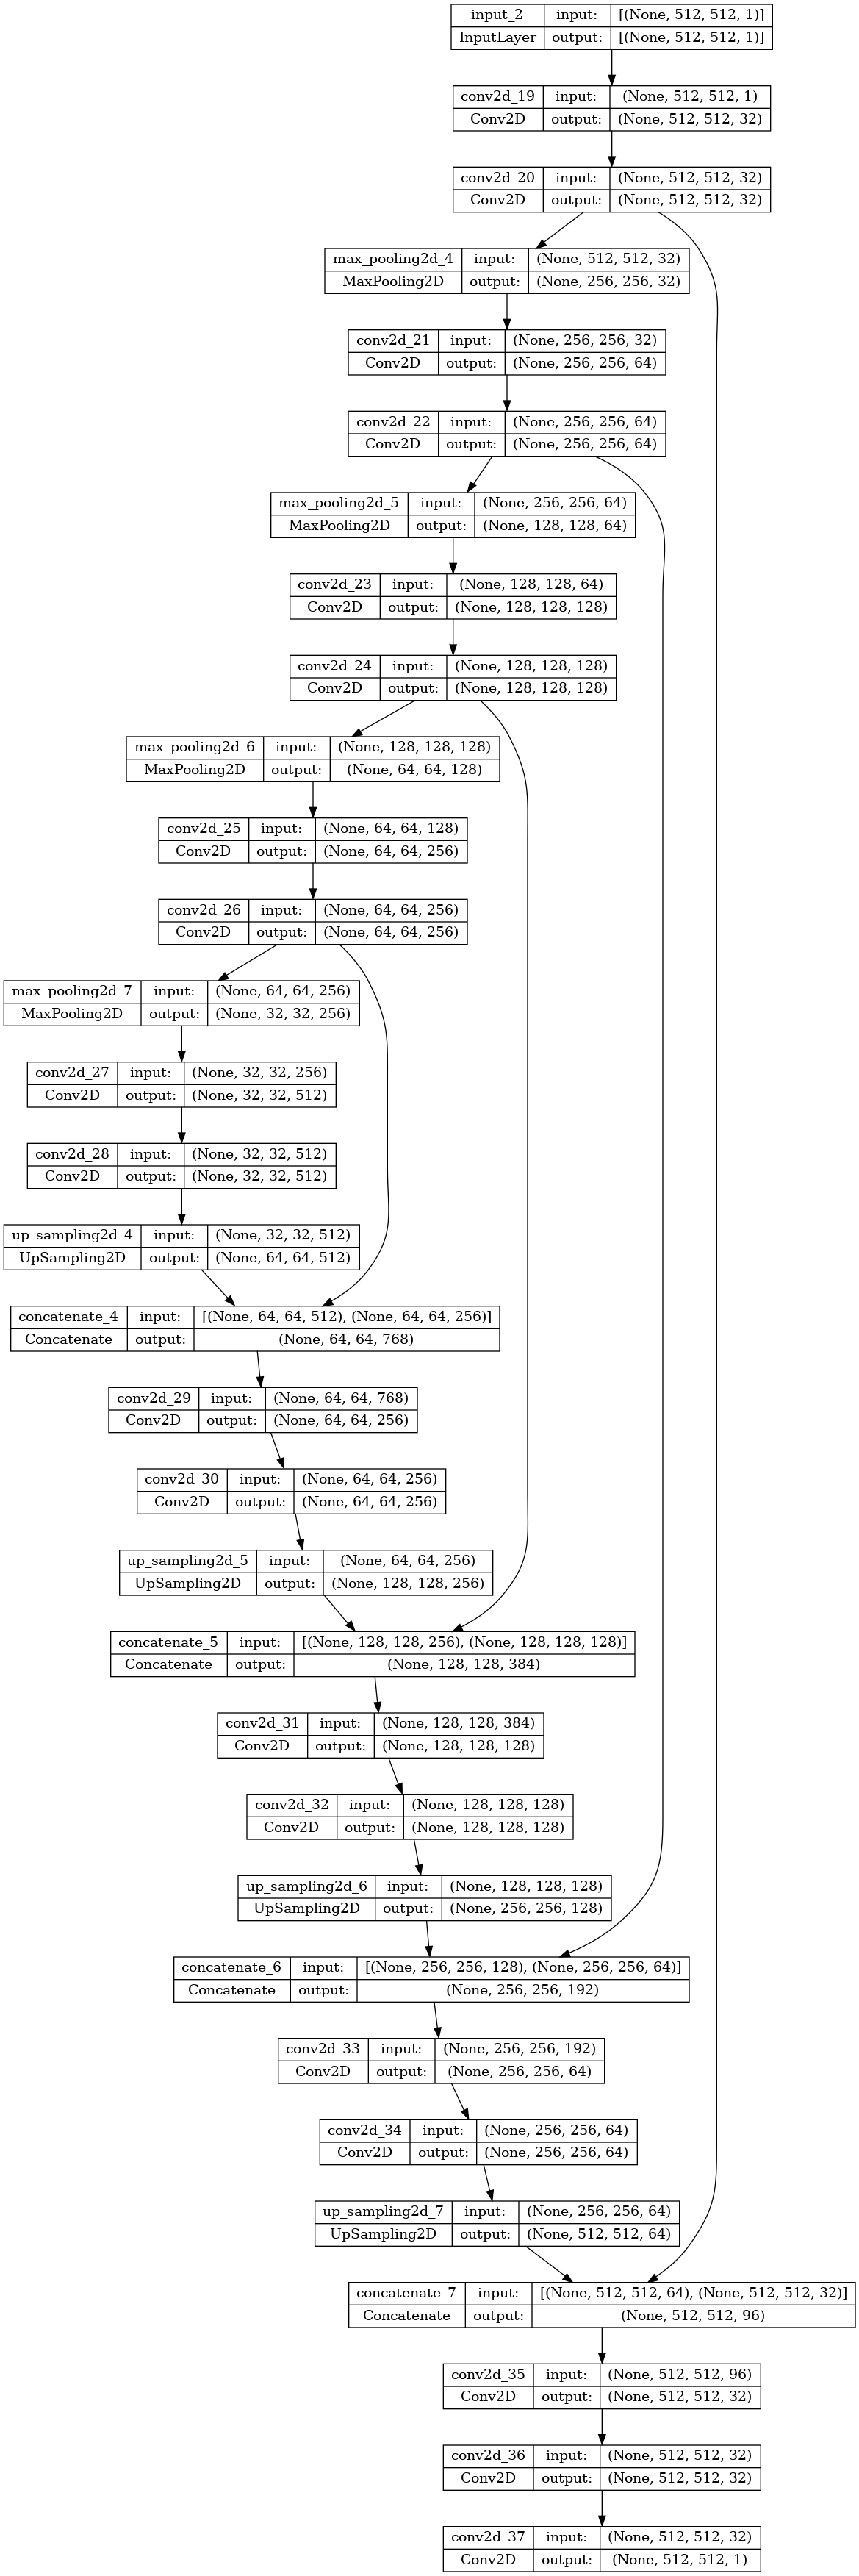

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, rankdir='TB',
to_file='model_cifar10.png')

In [14]:
X1 = np.load("/kaggle/input/data12/X1.npy")
X0 = np.load("/kaggle/input/data12/X0.npy")
Y1 = np.load("/kaggle/input/data12/mask1.npy")
Y0 = np.load("/kaggle/input/data12/mask0.npy")

In [15]:
X1.shape

(1153, 512, 512, 1)

In [16]:
X = np.concatenate((X1,X0),axis=0)
Y = np.concatenate((Y1,Y0),axis=0)

In [17]:
X1 =0
Y1=0
X0 =0
Y0=0

In [18]:
X = X/255
Y= Y/255

In [20]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.20,random_state=48)

In [22]:

X =0
Y=0

In [23]:
from tensorflow.keras.layers import Flatten
def iou_score(y_true, y_pred):
    intersection = 0 
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection =  (2.*(y_true_f * y_pred_f) + tf.keras.backend.epsilon())
    union = (y_true_f + y_pred_f + tf.keras.backend.epsilon())
    return (intersection/union)

In [24]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss = "BinaryCrossentropy",metrics=[iou_score])

In [25]:
hist = model.fit(Xtrain,Ytrain,epochs=50,batch_size=16,validation_data=(Xtest,Ytest))

Epoch 1/50
72/72 [==============================] - 67s 667ms/step - loss: 0.1450 - iou_score: 0.4033 - val_loss: 0.0058 - val_iou_score: 0.0163
Epoch 2/50
72/72 [==============================] - 44s 613ms/step - loss: 0.0039 - iou_score: 0.1669 - val_loss: 0.0038 - val_iou_score: 0.2584
Epoch 3/50
72/72 [==============================] - 44s 613ms/step - loss: 0.0036 - iou_score: 0.2656 - val_loss: 0.0039 - val_iou_score: 0.2389
Epoch 4/50
72/72 [==============================] - 44s 612ms/step - loss: 0.0036 - iou_score: 0.2768 - val_loss: 0.0039 - val_iou_score: 0.3459
Epoch 5/50
72/72 [==============================] - 46s 644ms/step - loss: 0.0035 - iou_score: 0.3000 - val_loss: 0.0039 - val_iou_score: 0.3862
Epoch 6/50
72/72 [==============================] - 46s 644ms/step - loss: 0.0036 - iou_score: 0.3165 - val_loss: 0.0037 - val_iou_score: 0.2811
Epoch 7/50
72/72 [==============================] - 44s 612ms/step - loss: 0.0035 - iou_score: 0.3329 - val_loss: 0.0036 - val_iou

In [26]:
Ytrain = 0
Xtrain = 0

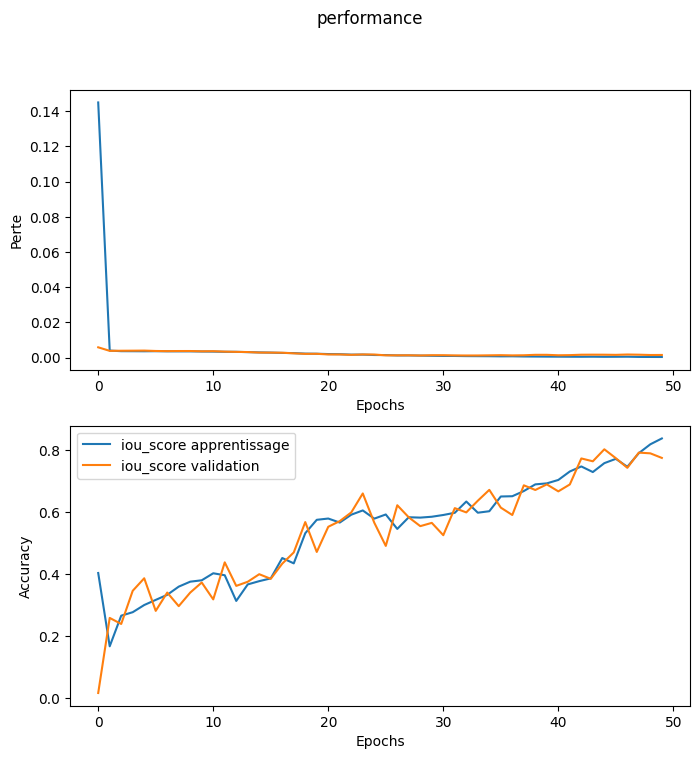

In [27]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte") 
plt.subplot(2, 1, 2)
plt.plot(np.arange(0, 50), hist.history["iou_score"], label="iou_score apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_iou_score"], label="iou_score validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")


plt.legend()


In [28]:
model.evaluate(Xtest,Ytest,batch_size=16)

18/18 [==============================] - 3s 164ms/step - loss: 0.0015 - iou_score: 0.7744


[0.0014526158338412642, 0.7743901610374451]

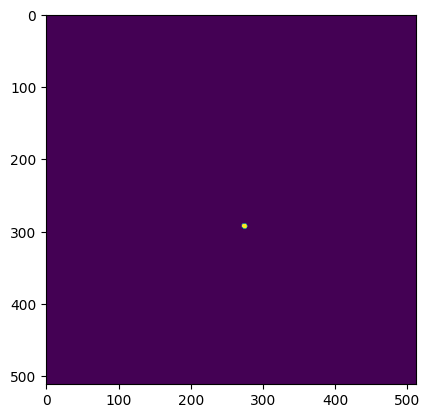

In [30]:
plt.imshow(Ytest[8])

In [35]:
#X = np.load("/kaggle/input/data12/X0.npy")
#X = X/255

y_1 = model.predict(Xtest[8].reshape((1,512,512, 1)))


1/1 [==============================] - 0s 26ms/step


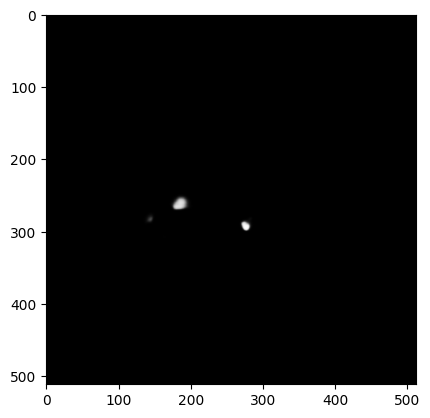

In [36]:
y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [37]:
y_1.max()

0.9834435

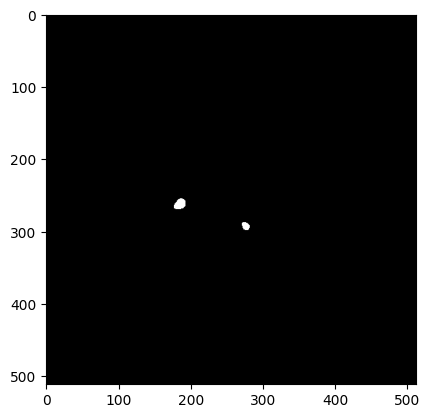

In [38]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [39]:

norm_img = Xtest[8].reshape((512,512))
img = norm_img * 255

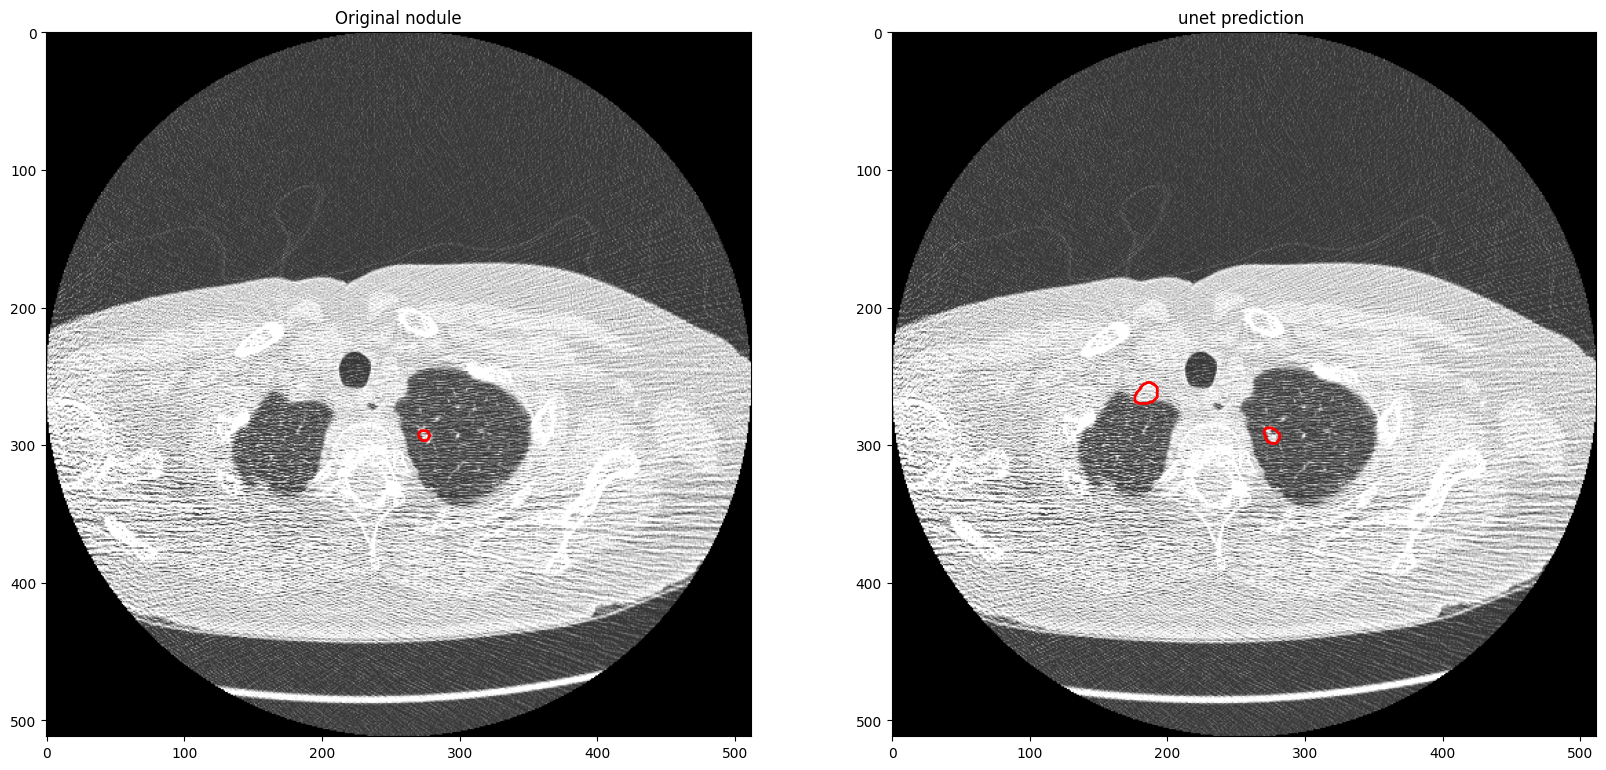

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('unet prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[8].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()

In [41]:
model.save("unet.h5")